In [18]:
import cv2
import numpy as np
import PIL.Image as Image
import tensorflow as tf

from io import BytesIO
from IPython.display import display
from pathlib import Path
from PIL import Image, JpegImagePlugin
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2  # type: ignore
from tqdm import tqdm
from typing import Dict, List, Tuple

In [3]:
IMAGE_SHAPE: Tuple[int, int] = (224, 224)
model = MobileNetV2(input_shape=IMAGE_SHAPE + (3,))

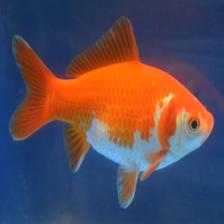

In [3]:
Image.open("goldfish.jpg").resize(IMAGE_SHAPE).save("goldfish_resized.jpg")

goldfish: JpegImagePlugin.JpegImageFile = Image.open("goldfish_resized.jpg")
display(goldfish)

In [4]:
goldfish: np.ndarray = np.array(goldfish) / 255.0
goldfish = goldfish[np.newaxis, ...]
goldfish.shape

(1, 224, 224, 3)

In [5]:
result: np.ndarray = model.predict(goldfish)

labels: List[str] = []
with open("labels.txt", "r") as file:
    labels = file.read().splitlines()

label: int = labels[np.argmax(result[0])]
confidence: float = result[0][np.argmax(result[0])]
print(label, confidence)

1/1 [==============================] - 1s 1s/step

1: 'goldfish, Carassius auratus', 0.9084121


In [4]:
ds_url: str = (
    "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
)

ds_dir: Path = Path(
    tf.keras.utils.get_file("flower_photos", ds_url, cache_dir=".", untar=True)
)

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [5]:
flower_images_dict: Dict[str, List[Path]] = {
    "daisy": list(ds_dir.glob("daisy/*.jpg")),
    "dandelion": list(ds_dir.glob("dandelion/*.jpg")),
    "roses": list(ds_dir.glob("roses/*.jpg")),
    "sunflowers": list(ds_dir.glob("sunflowers/*.jpg")),
    "tulips": list(ds_dir.glob("tulips/*.jpg")),
}

flower_labels_dict: Dict[str, int] = {
    "daisy": 0,
    "dandelion": 1,
    "roses": 2,
    "sunflowers": 3,
    "tulips": 4,
}

In [6]:
X: List[np.ndarray] = []
y: List[int] = []

for flower_name, images in tqdm(flower_images_dict.items()):
    for _ in images:
        img: np.ndarray = cv2.imread(str(_))
        img = cv2.resize(img, IMAGE_SHAPE)

        X.append(img)
        y.append(flower_labels_dict[flower_name])

X: np.ndarray = np.array(X)
y: np.ndarray = np.array(y)

100%|██████████| 5/5 [00:10<00:00,  2.12s/it]


In [7]:
X_train: np.ndarray
X_test: np.ndarray
y_train: np.ndarray
y_test: np.ndarray
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train = X_train / 255
X_test = X_test / 255

In [24]:
num_classes: int = 5

feat_extractor = MobileNetV2(input_shape=IMAGE_SHAPE + (3,), include_top=False)
feat_extractor.trainable = False

model = tf.keras.Sequential(
    [
        tf.keras.Input(shape=IMAGE_SHAPE + (3,)),
        feat_extractor,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(num_classes),
    ]
)

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [25]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

model.fit(X_train, y_train, epochs=5)

Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.5183 - loss: 1.1868
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 111s 711ms/step - accuracy: 0.8283 - loss: 0.4669
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 80s 688ms/step - accuracy: 0.8660 - loss: 0.3738
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 83s 701ms/step - accuracy: 0.9003 - loss: 0.3072
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 82s 704ms/step - accuracy: 0.9164 - loss: 0.2693


In [26]:
model.evaluate(X_test, y_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 18s 704ms/step - accuracy: 0.8338 - loss: 0.4979


[0.438527375459671, 0.8514986634254456]